# CovidAB - Populations
- using the data at http://www.ahw.gov.ab.ca/IHDA_Retrieval/selectSubCategory.do

### This supports the main notebook - CovidAB

In [2]:
# STANDARD IMPORTS  
from datetime import datetime
import glob
import json
import math
import io
import os
import csv
from flatten_json import flatten
import operator
from collections import Counter

# Pandas +
import pandas as pd
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
from pivottablejs import pivot_ui
import pandas_profiling

# Selenuim webscraping
import time
from selenium import webdriver
import chromedriver_binary  # Adds chromedriver binary to path
from selenium.webdriver.chrome.options import Options


## Get the Data  
- AHS makes downloading data at http://www.ahw.gov.ab.ca/IHDA_Retrieval/selectSubCategory.do 
  even more complicated than the COVID site.  
- So manually download and put into download_folder
- Only 2019 - counts should be:

    Geography	Year	Sex	Age	Population  
    Alberta	2019	BOTH	ALL	4,371,324


In [12]:
# Download to with 'rawData' folder. 
download_folder = './rawData'
if not os.path.exists(download_folder):
    os.makedirs(download_folder)
download_folder = download_folder + '/'

In [21]:
# Outputs to with 'results' folder. 
output_folder = './results'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
output_folder = output_folder + '/'

## Investigate with Pandas ....

In [17]:
csv_file = 'covid19-AHS-Population-DataFilterExport.csv'

In [18]:
# supporting data - population  
df = pd.read_csv(download_folder + csv_file)
df.shape

(21645, 5)

In [37]:
#Standard pandas settings  
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None
pd.set_option('mode.chained_assignment', None) # disable the SettingwithCopyWarning

In [38]:
# see the default pandas charts in notebook  
%matplotlib inline

In [39]:
# good step - include some meta data in the dataframe
df.name = csv_file
df['file_name'] = csv_file

In [40]:
df.sample(15)

,geography,year,gender,age_group,population,file_name
13757,HSA4.2.A,2019,MALE,13,476.0,covid19-AHS-Population-DataFilterExport.csv
4991,HSA2.2.B,2019,MALE,88,43.0,covid19-AHS-Population-DataFilterExport.csv
8089,HSA2.5.BC,2019,FEMALE,11,270.0,covid19-AHS-Population-DataFilterExport.csv
612,HSA1.1,2019,BOTH,72,403.0,covid19-AHS-Population-DataFilterExport.csv
4718,HSA2.2.B,2019,MALE,80to84,519.0,covid19-AHS-Population-DataFilterExport.csv
14924,HSA4.2.DE,2019,MALE,69,343.0,covid19-AHS-Population-DataFilterExport.csv
19138,HSA4.9,2019,FEMALE,31,393.0,covid19-AHS-Population-DataFilterExport.csv
12158,HSA3.7.BC,2019,MALE,35,545.0,covid19-AHS-Population-DataFilterExport.csv
15398,HSA4.3.B,2019,MALE,05,337.0,covid19-AHS-Population-DataFilterExport.csv
5438,HSA2.3.B,2019,MALE,15,780.0,covid19-AHS-Population-DataFilterExport.csv


In [23]:
# various functions ....
# df.info()
# df.columns
# df.index.name
# 
df.dtypes

Geography      object
Year            int64
Sex            object
Age            object
Population    float64
file_name      object
dtype: object

### Cleanup base data

In [24]:
#rename
df.columns = ['geography','year', 'gender', 'age_group', 'population','file_name'] 

**Note** - there is "over reporting" 
- for example: individual ages, are in age_groups and also totals
- so going to be flagging and pulling out just the gender/age_group/ahs_zone info that 
  will align with the **CovidAB** notebook data  

In [50]:
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Num_Unique'])
unique_counts

,Column_Name,Num_Unique
0,geography,65
1,year,1
2,gender,3
3,age_group,111
4,population,3838
5,file_name,1


In [43]:
# names of geograhy need some help

# !!! manually pulled from the website and cleaned into CSV like this!!!

ahs_zones_file = 'AHS.csv'
df_ahs_zones = pd.read_csv(download_folder + ahs_zones_file)
df_ahs_zones.sample(5)

,ahs_zone,ahs_zone_name,ahs_subzone,ahs_subzone_name
40,HSA4,Edmonton Zone,HSA4.2.A,Edmonton - Castle Downs
56,HSA4,Edmonton Zone,HSA4.9,St. Albert
1,HSA1,South Zone,HSA1.2,South Zone - Central
6,HSA1,South Zone,HSA1.5.C,Lethbridge - South
39,HSA4,Edmonton Zone,HSA4.1.D,Edmonton West Jasper Place


In [54]:
df_ahs_zones.columns

Index(['ahs_zone', ' ahs_zone_name', ' ahs_subzone', ' ahs_subzone_name'], dtype='object')

In [47]:
unique_counts = pd.DataFrame.from_records([(col, df_ahs_zones[col].nunique()) for col in df_ahs_zones.columns],
                          columns=['Column_Name', 'Num_Unique'])
unique_counts

,Column_Name,Num_Unique
0,ahs_zone,5
1,ahs_zone_name,5
2,ahs_subzone,64
3,ahs_subzone_name,64


In [55]:
# join - inner loan - should just have what we want
df_population = df.merge(df_ahs_zones, left_on='geography', right_on='ahs_subzone', how='left')
df_population.sample(5)

KeyError: 'ahs_subzone'

In [13]:
# reset index
df.reset_index(drop=True, inplace=True)

In [14]:
# add a "counter" to have a numeric
df['case_count'] = 1
# and a running total
df['running_total']=df['case_count'].expanding().sum().astype('int')

### Agregations

In [25]:
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Num_Unique'])
unique_counts

,Column_Name,Num_Unique
0,geography,65
1,year,1
2,gender,3
3,age_group,111
4,population,3838
5,file_name,1


In [26]:
# Define summary aggregations as a template
aggregations = {'population':['count','sum']}

In [27]:
# this does the groups, and then creates "total" using the fileName column
# the "astype(str)" is because most columns are category types
df_summary = df.groupby(df['geography'].astype(str)).agg(aggregations)
df_summary = df_summary.append(df.groupby(df['file_name'].astype(str)).agg(aggregations))
df_summary

population            
                                                 count         sum
AB                                                 333  26066691.0
HSA1.1                                             333    225812.0
HSA1.2                                             333    367118.0
HSA1.3                                             333    252441.0
HSA1.4                                             333    405634.0
HSA1.5.A                                           333    221325.0
HSA1.5.B                                           333    165008.0
HSA1.5.C                                           333    202515.0
HSA2.1.A                                           333    727850.0
HSA2.1.B                                           333    683179.0
HSA2.1.C                                           333    462015.0
HSA2.1.D                                           333    373557.0
HSA2.1.EF                                          333    390605.0
HSA2.2.A                                           333    685609.0
HSA2.2.B                                           333    574754.0
HSA2.3.A                                           333    432574.0
HSA2.3.B                                           333    780747.0
HSA2.4.A                                           333    547254.0
HSA2.4.B                                           333    395301.0
HSA2.4.C                                           333    388538.0
HSA2.4.D                                           333    243005.0
HSA2.4.E                                           333    670213.0
HSA2.4.F                                           333    684488.0
HSA2.5.A                                           333    269699.0
HSA2.5.BC                                          333    270261.0
HSA2.6.AB                                          333    573992.0
HSA2.6.C                                           333    363163.0
HSA2.7.A                                           333    294281.0
HSA2.7.B                                           333    241507.0
HSA3.1                                             333    230119.0
HSA3.2                                             333    492291.0
HSA3.3                                             333    267266.0
HSA3.4                                             333    470657.0
HSA3.5                                             333    390481.0
HSA3.6                                             333    351582.0
HSA3.7.A                                           333    212797.0
HSA3.7.BC                                          333    418939.0
HSA4.1.A                                           333    359612.0
HSA4.1.B                                           333    193480.0
HSA4.1.C                                           333    280203.0
HSA4.1.D                                           333    602534.0
HSA4.2.A                                           333    420424.0
HSA4.2.B                                           333    490572.0
HSA4.2.C                                           333    433035.0
HSA4.2.DE                                          333    616774.0
HSA4.3.A                                           333    575496.0
HSA4.3.B                                           333    304706.0
HSA4.3.C                                           333    495100.0
HSA4.4.A                                           333    240751.0
HSA4.4.B                                           333    451489.0
HSA4.4.C                                           333    620039.0
HSA4.5.A                                           333    179876.0
HSA4.5.B                                           333    194319.0
HSA4.6                                             333    590626.0
HSA4.7                                             333    455777.0
HSA4.8.A                                           333    341640.0
HSA4.8.B                                           333    218934.0
HSA4.9                                             333    410974.0
HSA5.1                  

### 0.2 - Basic Plotting  
- built into pandas  

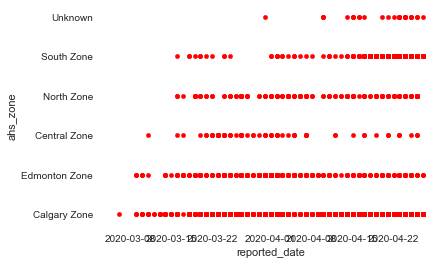

In [18]:
df.plot(kind='scatter',x='reported_date',y='ahs_zone',color='red')
plt.show()

## Part 2 - Pivot Table  
This is not excel - but VERY handy  
- just drag and drop  
- and simple charts, heat maps, etc  

In [29]:
pivot_ui(df)

## Part 3 - Profiling  
- create way to save results when archiving data after analysis  

In [20]:
# pandas_profiling.ProfileReport(df)

# NOTE: Currently not working ....
# pandas                    1.0.3            py37h6c726b0_0  
# pandas-profiling          2.6.0                      py_0    conda-forge


## Outputs 

In [22]:
# save the data
output_file_name = "CovidAB_" + datetime.today().strftime('%Y%m%d') + ".csv"
print(output_folder + output_file_name)
df.to_csv(output_folder + output_file_name)

./results/CovidAB_20200428.csv


In [23]:
# save profile
# ppr = pandas_profiling.ProfileReport(df)
# output_file_name = "CovidAB_Profile_" + datetime.today().strftime('%Y%m%d') + ".html"
# print(output_folder + output_file_name)
# ppr.to_file(output_folder + output_file_name)

# Done